<b>Apollo 13 Transcript Exploratory Analysis</b>

The goal is to examine the transcript from the Apollo 13 mission to see if any interesting insights can be gleamed. The Apollo 13 was the famous mission to the moon that almost ended in disaster when an oxygen tank on board exploded.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.util import ngrams
import string
from collections import Counter

In [2]:
df = pd.read_table('cleanedData.txt')
df.head()

time speaker                         text
0  000:00:02     CDR        The clock is running.
1  000:00:03     CMP              Okay. P11, Jim.
2  000:00:05     CDR                 Yaw program.
3  000:00:12     CMP             Clear the tower.
4  000:00:14     CDR  Yaw complete. Roll program.

First, lets take a look at how many messages were sent by each speaker in descending order.

In [3]:
speakerCounts = df.groupby('speaker').size().sort_values(ascending = False)
print speakerCounts

speaker
CC     4805
CDR    2333
LMP    1942
CMP    1732
F        21
SC       20
R        10
IWO       6
S-2       2
S-l       1
S-1       1
R-l       1
P-l       1
P-1       1
dtype: int64


On lines 76-93 of the original text file lists the meaning of these acronyms.

Spacecraft:
* CDR - Commander - James A. (Jim) Lovell, Jr.
* CMP - Command module pilot - John L. Swigert, Jr.
* LMP - Lunar module pilot - Fred W. Haise, Jr.
* SC - Unidentified crewmember

Mission Control Centers:
* CC - Capsule communicator (CAP COMM)
* F - Flight director
* S - Surgeon

Remote sites:
* IWO - USS Iwo Jima
* P-l, P-2, etc.            Photographic helicopters
* R-l, R-2, etc.            Recovery helicopters

The multiples of S-1/S-L and P-1/P-L are most likely just transcription errors where an L was used instead of a 1.

The messages from the astronauts and the Cap Comm seem to dwarf everything else, so lets make a bar plot of using only that data.

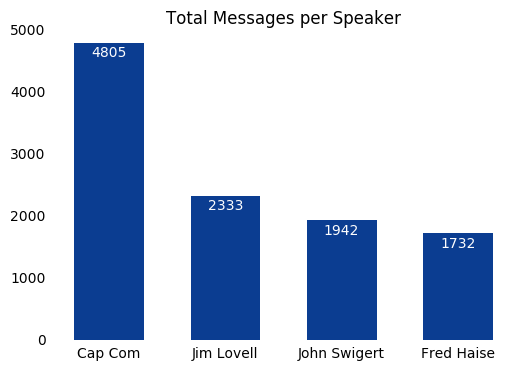

In [4]:
speakerCounts = speakerCounts.iloc[0:4]
xPos = range(len(speakerCounts)) # create a range of numbers for each bar in bar plot

plt.bar(xPos, speakerCounts,
        color='#0B3D91', # NASA blue
        align='center',
        linewidth=0, 
        width=0.6,
        zorder=2)

names = ['Cap Com', 'Jim Lovell', 'John Swigert', 'Fred Haise']
plt.xticks(xPos, names) # placing name labels
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on") # removing tick marks 
plt.title('Total Messages per Speaker') # add title

# removing borders
ax = plt.gca()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  

# adding labels on each bar
rects = ax.patches
labels = speakerCounts
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height-50, label, ha='center', va='top', color='white')
    
plt.show()

I defined a few more columns to make dealing with time throughout the notebook a little easier. One being the total time elapsed in seconds, the other being what hour of the mission it is.

In [5]:
df['seconds'] = df.time.str.split(':').apply( lambda x: int(x[0]) * 3600 + int(x[1]) * 60 + int(x[2]) )
df['hour'] = df.time.str.split(':').apply( lambda x: int(x[0]) )

df.head()

time speaker                         text  seconds  hour
0  000:00:02     CDR        The clock is running.        2     0
1  000:00:03     CMP              Okay. P11, Jim.        3     0
2  000:00:05     CDR                 Yaw program.        5     0
3  000:00:12     CMP             Clear the tower.       12     0
4  000:00:14     CDR  Yaw complete. Roll program.       14     0

The next thing I wanted to look at was the length of each message to see if there was any difference after the explosion and to get a general idea of the timeline of messages.

In [6]:
df['length'] = df.text.str.len() # adding a column to dataframe to represent length of each message
df.head()

time speaker                         text  seconds  hour  length
0  000:00:02     CDR        The clock is running.        2     0      21
1  000:00:03     CMP              Okay. P11, Jim.        3     0      15
2  000:00:05     CDR                 Yaw program.        5     0      12
3  000:00:12     CMP             Clear the tower.       12     0      16
4  000:00:14     CDR  Yaw complete. Roll program.       14     0      27

Before I plot I wanted to find the famous <i>"Houston, we've had a problem"</i> message so I could highlight it in the plot. This is the point where the one of the spacecrafts oxygen tanks blew up.

In [7]:
problem = df[df.text == "Houston, we've had a problem. We've had a MAIN B BUS UNDERVOLT."]
problem # print

time speaker                                               text  \
2199  055:55:35     CDR  Houston, we've had a problem. We've had a MAIN...   

      seconds  hour  length  
2199   201335    55      63

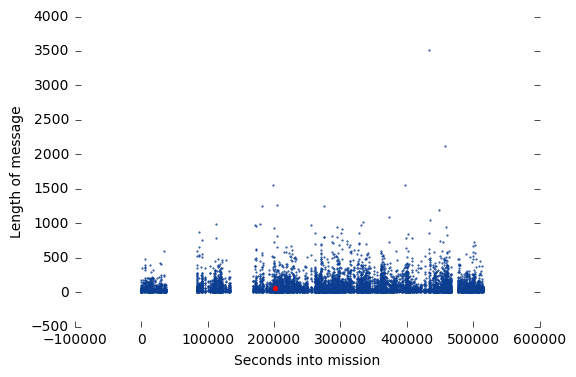

In [8]:
plt.scatter(df.seconds, df.length,
            marker = '.', 
            color = '#0B3D91',
            s = 1)
plt.xlabel('Seconds into mission') # add xlabel
plt.ylabel('Length of message') # ylabel
plt.tick_params(axis="both", which="both", bottom="on", top="off", labelbottom="on", left="on", right="on", labelleft="on") # removing top tick marks 

# removing borders
ax = plt.gca()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  

plt.scatter(problem.seconds,problem.length,
           marker = '.',
           color = 'red', # change color to red to stand out
           s = 30) # make size larger to stand out

plt.show()

Next, I wanted to create a histogram to look at the message frequency. I opted to create bins for each hour of the mission.

In [9]:
dfByHour = pd.DataFrame(df.groupby('hour').size(), columns = ['totalMessages']) # create new DF for data grouped by hour
newIndex = [x for x in range(df.hour.min(), df.hour.max() + 1)] # create new index so for accurate bar plot
dfByHour = dfByHour.reindex(newIndex, fill_value = 0) # assign new index

Now for plotting (I'll highlight the hour where the explosion occured):

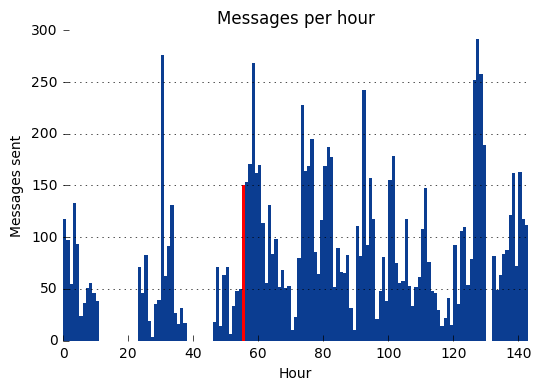

In [10]:
plt.bar(dfByHour.index, dfByHour.totalMessages,
       color='#0B3D91',
        linewidth=0,
        width=1.0)

plt.tick_params(axis="both", which="both", bottom="on", top="off", labelbottom="on", left="on", right="off", labelleft="on") # remove tick marks

# remocing borders
ax = plt.gca()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  

ax.yaxis.grid() # set grid


ax.set_xlim(0,143) # set x axis limits to fill plot

# set title and labels
plt.title('Messages per hour')
plt.ylabel('Messages sent')
plt.xlabel('Hour')

plt.bar(problem.hour, dfByHour.loc[problem.hour].totalMessages, 
        color = 'red',
        linewidth = 0,
        width = 1.0)

plt.show()

My main question from these two plots was: what was the reason for the three gaps seen in the data? My  first thought was that these were periods in the mission where there was no radio signal due to positioning, rentry, etc. However, the two larger gaps are quite a few hours long so this seems unlikely. By checking the messages around these gaps, it becomes obvious these were just times when the astronauts were sleeping.

From the first gap:

    023:11:17 CC    Good morning, 13. This is Houston- How are you?
    023:11:22 CDR   Read you loud and clear. We had a fairly good night's sleep.

From the second:

    046:43:18 CDR   Houston, Houston, Apollo 13. Over.
    046:43:22 CC    Good morning, 13, You're early.

And the third:

    132:28:45 CC    Fred, are you sleeping?
    132:28:54 LMP   Go ahead.

So clearly after the explosion, the astronauts got very little sleep which I couldn't blame them for.

<b>Common Words and Bigrams</b>

Next, I wanted to check out th most common words used and the most common bigrams(pairs of consecutive words).

In [11]:
myCorpus = df.text.str.cat(sep = ' ') # combine text column into one string
myCorpus = myCorpus.translate(None, string.punctuation) # remove punctuation
myCorpus = myCorpus.lower() # change to lowercase
myCorpus = myCorpus.split(' ') # split into individual words so we can count them up

stop = stopwords.words('english') + ['','thats'] # create a list of stopwords to remove from our corpus
stop = [str(word) for word in stop] # convert from unicode string to avoid error message
myCorpus = [word for word in myCorpus if word not in stop] # remove stopwords from corpus

countWords = Counter() # create counter objects for words and for bigrams
countBigrams = Counter()

countWords.update(myCorpus) # update counter object with stopword corpus to count all words

bigramCorpus = ngrams(myCorpus,3) # create bigrams
countBigrams.update(bigramCorpus) # update counter object with bigrams to count bigrams

print ('Most common words: ' , countWords.most_common(5))
print( 'Most common bigrams: ', countBigrams.most_common(5))

('Most common words: ', [('okay', 4419), ('houston', 1281), ('go', 1268), ('jack', 941), ('roger', 863)])
('Most common bigrams: ', [(('houston', 'go', 'ahead'), 272), (('go', 'ahead', 'okay'), 194), (('aquarius', 'houston', 'go'), 162), (('apollo', '13', 'houston'), 122), (('13', 'houston', 'go'), 103)])
